In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import IPython
import pyaudio
import pylab
import scipy as sp
import scipy.io.wavfile
import scipy.signal
from IPython.display import Audio
pylab.rcParams['figure.figsize'] = (16, 4)

## Utilities

In [2]:
def record(sec, rate, channels=1, chunk=1024):
    ex_format = pyaudio.paInt32
    p = pyaudio.PyAudio()
    stream = p.open(format=ex_format, channels=channels, rate=rate, input=True, frames_per_buffer=chunk)
    buf = []
    for i in range(0, int(rate / chunk * sec)):
        data = stream.read(chunk)
        buf.append(np.fromstring(data, 'Int32'))
    stream.stop_stream()
    stream.close()
    p.terminate()
    ex_chan = np.array(buf).flatten()
    ex_group = np.reshape(ex_chan, [len(ex_chan) / channels, channels])
    ex = [np.average(g) for g in ex_group]
    assert len(ex) == len(ex_chan) / channels
    return ex

In [3]:
def binarize(text):
    return [int(b) for c in text for b in "{0:08b}".format(ord(c))]

In [4]:
def textarize(binary):
    bin_str = [str(b) for b in binary]
    bin_chunks = ["".join(bin_str[c:c+8]) for c in range(0, len(bin_str), 8)]
    return "".join([chr(int(c, 2)) for c in bin_chunks])

In [5]:
def raised_cosine(freq, pulse_dt, rate, beta=0.5):
    np.seterr(invalid='ignore')
    pulse_t = np.linspace(0, pulse_dt, rate * pulse_dt)
    p_const = 4 * beta / (np.pi * np.sqrt(pulse_dt))
    p_cos = np.cos((1 + beta) * np.pi * pulse_t / pulse_dt) 
    p_sinc = (1 - beta) * np.pi / (4 * beta) * np.sinc((1 - beta) * pulse_t / pulse_dt)
    p_denomin = 1 - (4 * beta * pulse_t / pulse_dt) ** 2
    p_hosp = beta / (np.pi * np.sqrt(2 * pulse_dt)) * ((np.pi + 2) * np.sin(np.pi / (4 * beta)) + (np.pi - 2) * np.cos(np.pi / (4 * beta)))
    out = p_const * (p_cos + p_sinc) / p_denomin
    out[np.isnan(out)] = p_hosp
    out *= np.cos(2 * np.pi * freq * pulse_t)
    assert not any(np.isnan(out))    
    np.seterr(invalid='warn')
    return out

In [6]:
def fast_corr(data, pattern, verify=False):
    data_len = len(data)
    data_half_len = data_len // 2
    data_even = np.zeros(data_len * 2)
    data_even[data_half_len:data_half_len + data_len] = data
    corr = sp.signal.fftconvolve(data_even, pattern[::-1], mode='valid')
    ret = corr[data_half_len:data_half_len + data_len - len(signal_delim) + 1]
    if verify:
        assert np.allclose(ret, np.correlate(data, pattern))
    return ret

## Configuration

In [7]:
origin_dt = 1
analysis_dt = 10

rate = 44100 
freq_min = 800
freq_max = 6000

pulse_dt = 0.01
pulse_df = 350
pulse_bits = 4
pulse_window = 16

## Channel analysis

In [8]:
#channel = record(analysis_dt, rate)
#Audio(channel, rate=rate)

In [9]:
channel_rate1, channel1 = sp.io.wavfile.read("interference.wav")
channel_rate2, channel2 = sp.io.wavfile.read("interference2.wav")
channel_rate3, channel3 = sp.io.wavfile.read("interference3.wav")
channel1 = channel1[:channel_rate1 * analysis_dt]
channel2 = channel2[:channel_rate2 * analysis_dt]
channel3 = channel3[:channel_rate3 * analysis_dt]
channel1 = sp.signal.resample(channel1, rate * analysis_dt)
channel2 = sp.signal.resample(channel2, rate * analysis_dt)
channel3 = sp.signal.resample(channel3, rate * analysis_dt)

In [10]:
channel = channel2
Audio(channel, rate=rate)

In [11]:
freq_noise = np.argsort(- np.fft.rfft(channel))[:2] / analysis_dt
freq_noise

array([  941.,  1336.])

In [12]:
t = np.linspace(0, analysis_dt, rate * analysis_dt)
channel_sim = np.cos(2 * np.pi * freq_noise[0] * t) + np.cos(2 * np.pi * freq_noise[1] * t)
Audio(channel_sim, rate=rate)

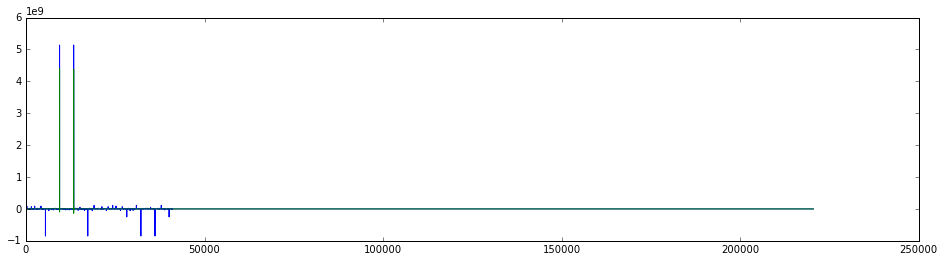

In [13]:
plt.plot(np.real(np.fft.rfft(channel)))
plt.plot(2e4 * np.real(np.fft.rfft(channel_sim)))

In [14]:
pulses_freq = np.arange(freq_min, freq_max, pulse_df)
for fn in freq_noise:
    pulses_freq = pulses_freq[np.abs(pulses_freq - fn) > pulse_df]
pulses_freq= pulses_freq[:]
pulses_freq


array([1850, 2200, 2550, 2900, 3250, 3600, 3950, 4300, 4650, 5000, 5350,
       5700])

## Pulse design

In [15]:
pulses = {i: raised_cosine(pulses_freq[i], pulse_dt, rate) for i in np.arange(0, len(pulses_freq))}
len(pulses)

12

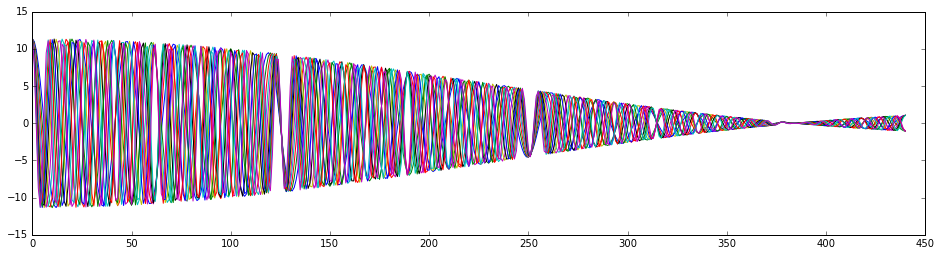

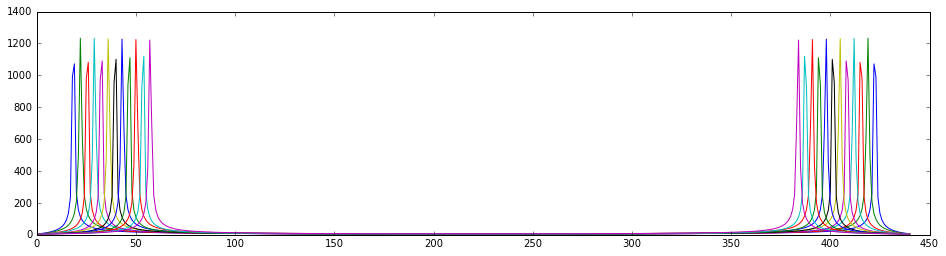

In [16]:
for i in pulses:
    plt.plot(pulses[i])
plt.show()

for i in pulses:
    plt.plot(np.abs(np.fft.fft(pulses[i])))

## Emitter

In [17]:
textfile = open('textfile.txt', 'r')
message = textfile.read()[:-1]
textfile.close()

In [18]:
message_bin = binarize(message)
assert message == textarize(message_bin)
len(message_bin)

1096

In [19]:
signal_delim = pulses[0]
Audio(signal_delim, rate=rate)

In [20]:
signal_window = pulses[1]
Audio(signal_window, rate=rate)

In [21]:
signal_data = []
i = 0
for c in [message_bin[n:n + pulse_bits] for n in range(0, len(message_bin), pulse_bits)]:
    
    if i % pulse_window == 0:
        signal_data.extend(signal_window)
        
    i += 1
    
    p = np.zeros(len(pulses[0]))
    for b in np.arange(0, len(c)):
        p += (c[b] * 2 - 1) * pulses[b + 2]
        p += (c[b] * 2 - 1) * pulses[b + 2 + pulse_bits]
    signal_data.extend(p)



In [22]:
signal_delay = np.zeros(origin_dt * rate)
signal = np.concatenate((signal_delay, signal_delim, signal_data, signal_delim, signal_delay))
Audio(signal, rate=rate)

In [23]:
len(signal) / rate - 2 * origin_dt

2.9400000000000004

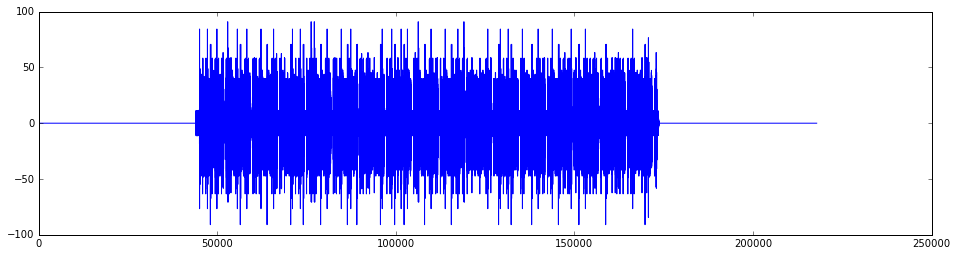

In [24]:
plt.plot(signal)

In [41]:
recorded = signal 

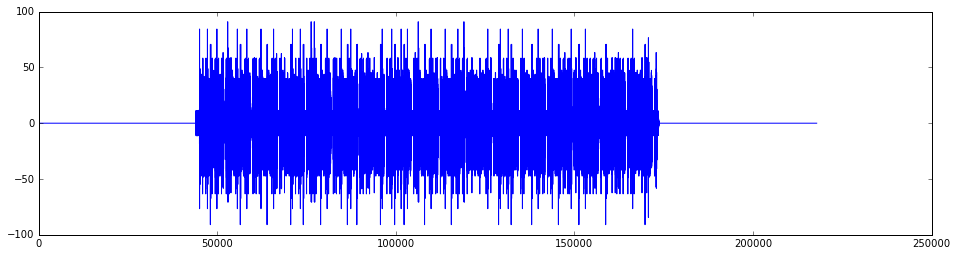

In [42]:
plt.plot(recorded)

## Receiver

In [39]:
recorded = record(5, rate)
Audio(recorded, rate=rate)

In [43]:
xcorr = fast_corr(recorded, signal_delim)

In [44]:
mid = len(xcorr) // 2
corr_end = len(xcorr) - np.argmax(xcorr[mid:][::-1])
corr_start = np.argmax(xcorr[:mid])
[corr_start, corr_end]

[44100, 173314]

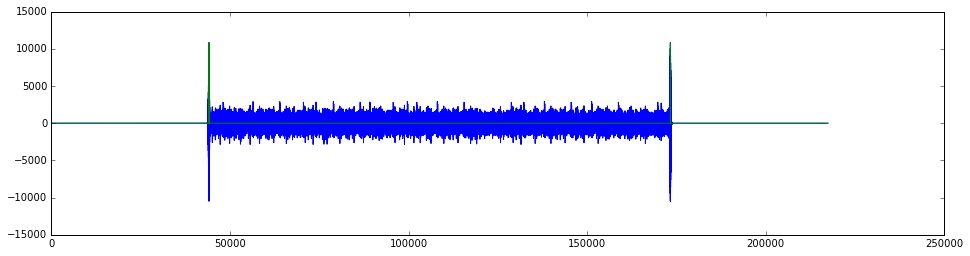

In [45]:
plt.plot(xcorr)
corr_bounds = np.zeros(len(xcorr))
corr_bounds[corr_start] = np.max(xcorr)
corr_bounds[corr_end] = np.max(xcorr)
plt.plot(corr_bounds)

In [90]:
isolated = recorded[corr_start + int(pulse_dt * rate):corr_end]

In [91]:
corr_window = fast_corr(isolated, signal_window)

In [92]:
window_width = int((pulse_window + 1) * pulse_dt * rate)
windows = [i + np.argmax(corr_window[i:i + pulse_window]) for i in np.arange(0, len(corr_window), window_width)]
len(windows)

18

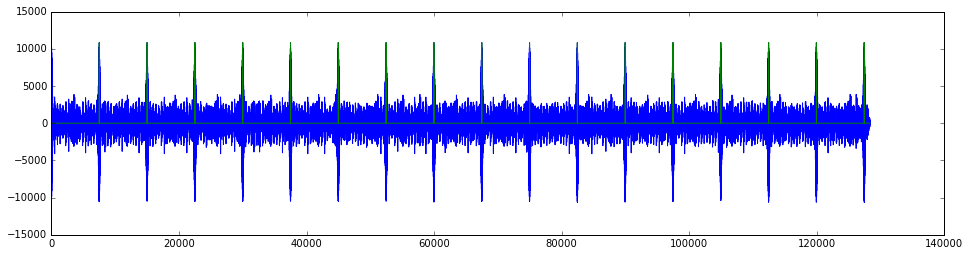

In [93]:
plt.plot(corr_window)
corr_window_bounds = np.zeros(len(corr_window))
for w in windows:
    corr_window_bounds[w] = np.max(corr_window)
plt.plot(corr_window_bounds)

In [96]:
decoded = ''

for w in windows:
    delimited = isolated[w:w + window_width][int(pulse_dt * rate):]
    matched = [fast_corr(delimited, pulses[i + 2]) for i in np.arange(0, pulse_bits+1)]
    matched2 = [fast_corr(delimited, pulses[i + 2]) for i in np.arange(0, pulse_bits+1)]
    matchedn = [fast_corr(delimited, -pulses[i + 2 + pulse_bits]) for i in np.arange(0, pulse_bits)]
    matchedn2 = [fast_corr(delimited, -pulses[i + 2 + pulse_bits]) for i in np.arange(0, pulse_bits)]
    sampled = [m[np.arange(0, len(m), int(pulse_dt * rate))] for m in matched]
    sampled2 = [m[np.arange(0, len(m), int(pulse_dt * rate))] for m in matched2]
    sampledn = [m[np.arange(0, len(m), int(pulse_dt * rate))] for m in matchedn]
    sampledn2 = [m[np.arange(0, len(m), int(pulse_dt * rate))] for m in matchedn2]

    for c in np.arange(0, len(sampled[0])):
        for b in np.arange(0, pulse_bits):
            decoded += '1' if sampled[b][c] + sampled2[b][c] > sampledn[b][c] + sampledn2[b][c] else '0'

received = textarize(decoded)
received

'The mediocre teacher tells. The good teacher explains. The superior teacher demonstrates. The great teacher gives reading assignments :-)'

In [36]:
def lcs(t1, t2):
    s1 = "".join([str(c) for c in t1])
    s2 = "".join([str(c) for c in t2])
    m = [[0] * (1 + len(s2)) for i in range(1 + len(s1))]
    longest, x_longest = 0, 0
    for x in range(1, 1 + len(s1)):
        for y in range(1, 1 + len(s2)):
            if s1[x - 1] == s2[y - 1]:
                m[x][y] = m[x - 1][y - 1] + 1
                if m[x][y] > longest:
                    longest = m[x][y]
                    x_longest = x
            else:
                m[x][y] = 0
    return s1[x_longest - longest: x_longest]